In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import cv2
import numpy as np

from tqdm import trange
import random

from skimage.feature import local_binary_pattern
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier



1. Represente a imagem usando:
1.1 BoVW detectando keypoints de forma aleatória.
1.2 BoVW detectando keypoints utilizando grid (definir o tamanho, por exemplo: 50x50)
1.3 LBP (representação nativamente global) ao invés de BoVW.

In [62]:
def random_sampling(image, num_points=300):
    
    height, width = image.shape
    keypoints = [cv2.KeyPoint(random.randint(0, width-1), random.randint(0, height-1), 10) for _ in range(num_points)]
    
    return keypoints


def grid_sampling(image, grid_size=(15, 15)):
    height, width = image.shape
    step_x, step_y = width // grid_size[0], height // grid_size[1]
    keypoints = [cv2.KeyPoint(x, y, 10) for x in range(0, width, step_x) for y in range(0, height, step_y)]
    return keypoints




# Image Display

In [3]:
def show_image_and_keypoints( image , kps ) :
    cv2.drawKeypoints( image, kps, image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS )

    plt.figure(figsize = (10,10))
    plt.imshow(image, aspect='auto')
    plt.axis('off')
    plt.title('Keypoints and descriptors.')
    plt.show()

In [4]:
def show_top_images ( dataset_path, indices , id_test , ids , labels ) :
    
    label = (ids[id_test] - 1) // 80

    name = dataset_path + '/jpg/' + str(label) + '/image_' + str(ids[id_test]).zfill(4) + '.jpg'
    image = cv2.imread( name )
    
    image = cv2.cvtColor( image , cv2.COLOR_BGR2RGB )
    
    top = 0
    show_image_label(top, image, labels[id_test], ids[id_test] )
    
    accuracy = 0
    
    for i in indices[0] :
        label_i = labels[i]
        name = dataset_path + '/jpg/' + str(label_i) + '/image_' + str(ids[i]).zfill(4) + '.jpg'

        image = cv2.imread( name )
        image = cv2.cvtColor( image , cv2.COLOR_BGR2RGB )

        show_image_label(top, image, label_i, ids[i] )   
        top = top + 1
        
    
def show_image_label ( top, image, label , image_id ) :
    
    plt.figure(figsize = (5,5))
    plt.imshow(image, aspect='auto')
    plt.axis('off')
    plt.title(f'{top} - Image id {image_id} with label {label}.')
    plt.show()

# Generate descriptors

In [26]:
def detect_and_describe_keypoints ( image, algorithm='orb' ) :
    
    image_gray = cv2.cvtColor( image , cv2.COLOR_BGR2GRAY )
        
    if algorithm == 'sift':
        detector = cv2.SIFT_create()
        keypoints = detector.detect(image_gray, None)

    elif algorithm == 'orb':
        detector = cv2.ORB_create()
        keypoints = detector.detect(image_gray, None)

    elif algorithm == 'random':
        detector = cv2.ORB_create()  # ou SIFT se quiser mudar
        keypoints = random_sampling(image_gray, num_points=300)

    elif algorithm == 'grid':
        detector = cv2.ORB_create()
        keypoints = grid_sampling(image_gray, (50, 50))
    else :
        print('Error: algorithm not defined')
        return None
    
    #kps = keypoint.detect( image_gray, None )    

    # Describing Keypoints
    kps, descs = detector.compute( image_gray, keypoints  )
    
    return kps, descs

In [15]:
def create_bovw_descriptors (image, dictionary, algorithm='orb') :
    
    descs = detect_and_describe_keypoints( image, algorithm=algorithm )[1]

    predicted = dictionary.predict(np.array(descs, dtype=np.double))
    
    desc_bovw = np.histogram(predicted, bins=range(0, dictionary.n_clusters+1))[0]
    
    return desc_bovw

def create_lbp_descriptor(image, radius=1, n_points=8):
   
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # LBP uniforme
    lbp = local_binary_pattern(gray, n_points, radius, method='uniform')

    # Histograma das ocorrências de padrões LBP
    hist, _ = np.histogram(
        lbp.ravel(),
        bins=np.arange(0, n_points + 3),
        range=(0, n_points + 2)
    )

    # Normalização
    hist = hist.astype('float')
    hist /= (hist.sum() + 1e-6)

    return hist

In [16]:
from sklearn.cluster import MiniBatchKMeans

def create_dictionary_kmeans ( vocabulary , num_cluster ) :
  
    print( ' -> [I] Dictionary Info:\n', 
        '\nTrain len: ', len(vocabulary),
        '\nDimension: ', len(vocabulary[0]),
        '\nClusters: ', num_cluster 
        )

    dictionary = MiniBatchKMeans( n_clusters=num_cluster, batch_size=1000 )

    print ( 'Learning dictionary by Kmeans...')
    dictionary = dictionary.fit( vocabulary )
    print ( 'Done.')

    return dictionary

# Data

In [17]:
import scipy.io
import tqdm

def create_vocabulary ( dataset_path , algorithm='orb', show_image=False , debug=False ) :

    mat = scipy.io.loadmat( dataset_path+'/datasplits.mat' )

    ids = mat['trn1'][0] #  'val1' or 'tst1' 
    
    if algorithm == 'orb' or algorithm == 'random' or algorithm == 'grid' :
        train_descs = np.ndarray( shape=(0,32) , dtype=float )
    elif algorithm == 'sift' :
        train_descs = np.ndarray( shape=(0,128) , dtype=float )
    else :
        print('Error:Algorithm not defined.')
        return None

    for id in tqdm.tqdm(ids, desc='Processing train set') :

        label = (id - 1) // 80
        name = dataset_path + '/jpg/' + str(label) + '/image_' + str(id).zfill(4) + '.jpg'

        image = cv2.imread( name )
        
        if image is None:
            print(f'Reading image Error. Path: {name}')
            return None

        kps, descs = detect_and_describe_keypoints ( image, algorithm=algorithm )
            
        train_descs = np.concatenate((train_descs, descs), axis=0)
        
        if show_image :
            show_image_and_keypoints(image, kps)

        if debug :
            print( name )
            print( 'Number of keypoints: ', len(kps) )
            print( 'Number of images: ', len(ids) )
            print( 'Descriptor size: ', len(descs[0]) )
            print( type(descs[0]) )
      
    print( ' -> [I] Image Loader Info:\n', 
      '\nTrain len: ', len(train_descs),
      '\nNumber of images: ', len(ids),
      '\nDescriptor size: ', len(descs[0])      
      )
    
    return train_descs

# Dictionary

In [46]:
def represent_dataset( dataset_path, dictionary=None , algorithm='orb' ) :

    mat = scipy.io.loadmat( dataset_path+'/datasplits.mat' )

    ids = mat['tst1'][0] #  'tst1' or 'trn1' or 'val1' 
    
    space = []
    labels = []
    
    for id in tqdm.tqdm(ids, desc='Processing test set') :

        label = (id - 1) // 80
        name = dataset_path + '/jpg/' + str(label) + '/image_' + str(id).zfill(4) + '.jpg'

        image = cv2.imread( name )
        
        if image is None:
            print(f'Reading image Error. Path: {name}')
            return None
        if algorithm == 'lbp':
            desc  = create_lbp_descriptor(image)
        else:
            desc  = create_bovw_descriptors(image, dictionary, algorithm=algorithm)

        space.append(desc)
        labels.append(label)
        
    print( ' -> [I] Space Describing Info:\n', 
        '\nNumber of images: ', len(space), 
        '\nNumber of labels: ', len(labels),
        '\nDimension: ', len(space[0])
        )

    return space , labels 

In [43]:
from sklearn.neighbors import NearestNeighbors

def run_test ( space , labels , dictionary , dataset_path, algorithm='orb', top=10 ) :
    knn = NearestNeighbors(n_neighbors=top+1).fit(space)
    
    mat = scipy.io.loadmat( dataset_path+'/datasplits.mat' )

    ids = mat['tst1'][0] #  'tst1' or 'trn1' or 'val1'
    
    accuracy_t = 0
    
    for id_test in tqdm.tqdm(ids, desc='running the test phase') :
        
        label = (id_test - 1) // 80
        name = dataset_path + '/jpg/' + str(label) + '/image_' + str(id_test).zfill(4) + '.jpg'

        image = cv2.imread( name )
        if algorithm == 'lbp':
            desc = create_lbp_descriptor(image)
        else:
            desc = create_bovw_descriptors(image, dictionary, algorithm=algorithm)

        indices = knn.kneighbors(desc.reshape(1, -1))[1]

        labels_top = [ labels[i] for i in indices[0] ]

        accuracy = sum( np.equal(labels_top, label) )
        accuracy =( (accuracy-1)/(top) ) * 100
        accuracy_t = accuracy_t + accuracy
        
    print(f'Average accuracy in the test set: {accuracy_t/len(ids):5.2f}%')
    

# Experimental evaluation

In [54]:
def retrieve_single_image ( space , labels , dictionary , dataset_path, algorithm='orb', top=10 ) :
    knn = NearestNeighbors(n_neighbors=top+1).fit(space)
    
    mat = scipy.io.loadmat( dataset_path+'/datasplits.mat' )

    ids = mat['tst1'][0] #  'trn1' or 'val1'
    
    id_test = random.randrange( len(ids) )
        
    label = (ids[id_test] - 1) // 80
    name = dataset_path + '/jpg/' + str(label) + '/image_' + str(ids[id_test]).zfill(4) + '.jpg'
    
    image = cv2.imread( name )
    
    if image is None:
        print(f'Reading image Error. Path: {name}')
        return None
    if algorithm == 'lbp':
        desc = create_lbp_descriptor(image)
    else:
        desc = create_bovw_descriptors(image, dictionary, algorithm=algorithm)
    
    distances, indices = knn.kneighbors(desc.reshape(1, -1))
    
    show_top_images(dataset_path, indices, id_test, ids, labels)
    
    labels_top = [ int(labels[i]) for i in indices[0] ]
    
    accuracy = sum( np.equal( label , labels_top ) )
    accuracy =( (accuracy-1)/(top) ) * 100 
    
    print(f'Accuracy for image id {ids[id_test]}: {accuracy:5.2f}%')
    
    print(name)    
    print(f'Image: {ids[id_test]} with label {labels[id_test]}')    
    print(f'Closest image: {ids[indices[0][0]]} with distance {distances[0][0]} and label {labels[indices[0][0]]}')
    print('Distances: ',distances)
    print('Indices: ',indices[0])
    print('Labels: ',labels_top)

In [55]:
ls

Dockerfile*           jpg-20250402T134911Z-001.zip*
Readme.md*            practice-1-ImageRetrieval-inf692.ipynb*
datasplits.mat*       requirements.txt*
docker-compose.yaml*  venv/
jpg/


# Execution

In [57]:
dataset_path = './'# ************* INSERT HERE YOUR DATASET PATH ******************
algorithm = 'lbp' # Chose the detector/descriptor: 'orb' or 'sift'
num_cluster = 100 # SET HERE THE BoVW DESCRIPTOR SIZE 
def execution_algoithm(dataset_path,algorithm,num_cluster ):
    if algorithm != 'lbp':
        # Create the vocabulary of visual words by detecting and describing all keypoints 
        # in all images in the training split of the dataset.
        vocabulary = create_vocabulary( dataset_path, algorithm=algorithm ) 
        
        # Clusterize the vocabulary of visual words detected and described in the training 
        # split of the dataset in $NUM_CLUSTER$ clusters.
        dictionary = create_dictionary_kmeans( vocabulary , num_cluster=num_cluster )
        
        # Using the centroids of the created clusters, represent all images in the testing split 
        # of the dataset. 
        space, labels = represent_dataset ( dataset_path , dictionary, algorithm=algorithm )
    else:
        dictionary = {}  
        space, labels = represent_dataset (dataset_path, dictionary={}, algorithm =algorithm)
    return space, labels, dictionary
space, labels, dictionary = execution_algoithm(dataset_path,algorithm,num_cluster )

Processing test set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:12<00:00, 28.22it/s]

 -> [I] Space Describing Info:
 
Number of images:  340 
Number of labels:  340 
Dimension:  10


In [58]:
# For each image of the testing split of the dataset, use the image as the query
# for the image retrieval problem, i.e., describe the image using the BoVW, and search
# for the k closest descriptors of the images in the testing split dataset. After that,
# measure the accuracy of the image retrieval by counting how many of the k retrieved 
# images has the same label of the query image, and divide it by k. This result will 
# the accuracy of the image retrieval result for that specific image. 
# Repeat it for each image of the testing split of the dataset and compute the average of 
# all calculated accuracies.
run_test( space, labels, dictionary, dataset_path, algorithm=algorithm )

running the test phase: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:11<00:00, 28.59it/s]

Average accuracy in the test set:  9.29%


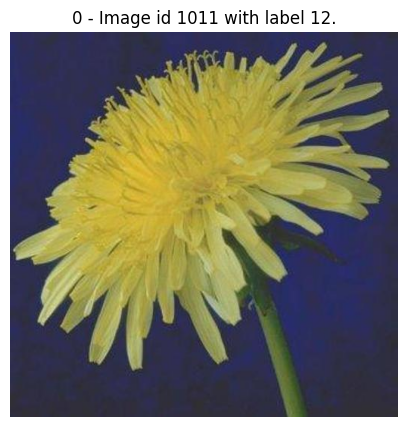

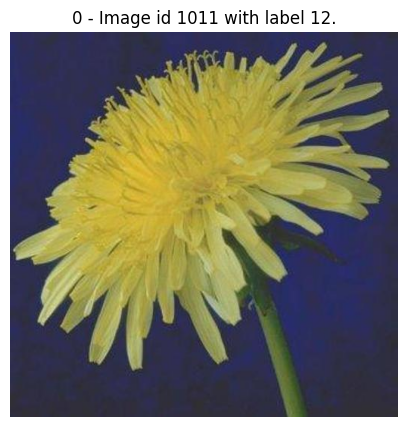

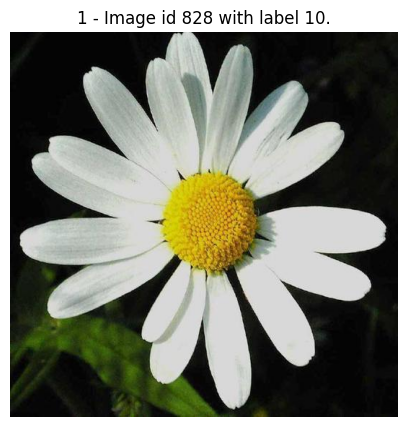

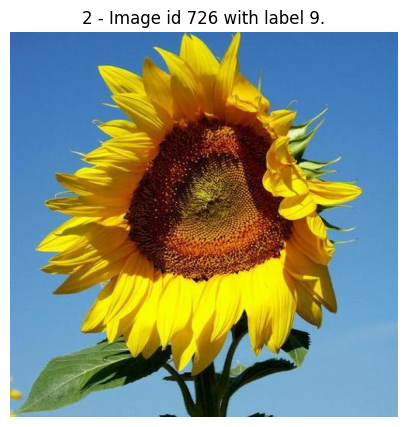

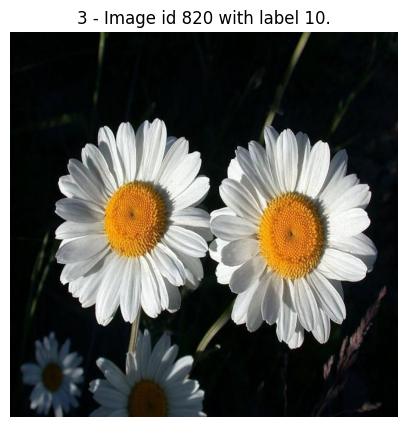

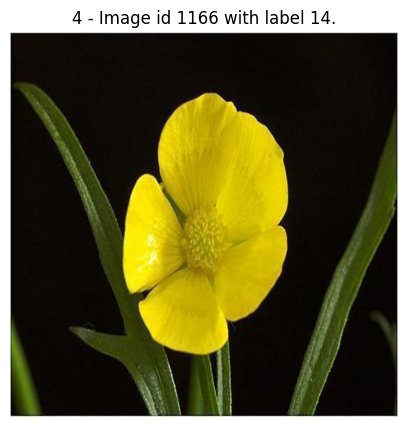

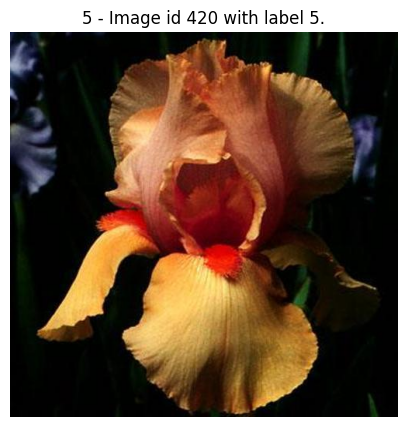

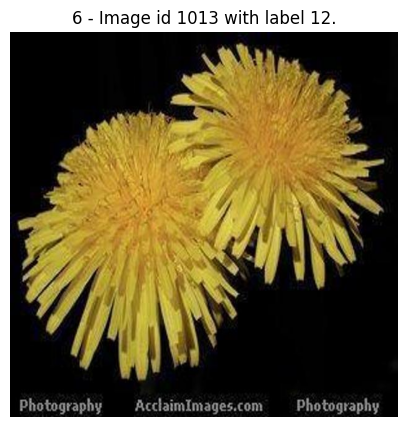

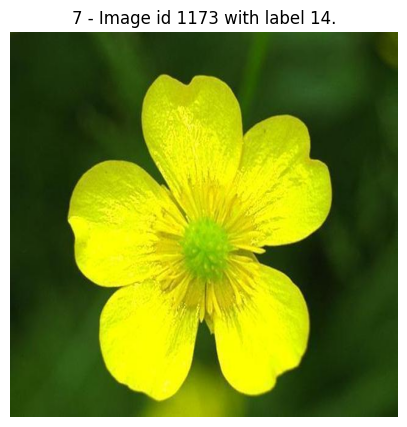

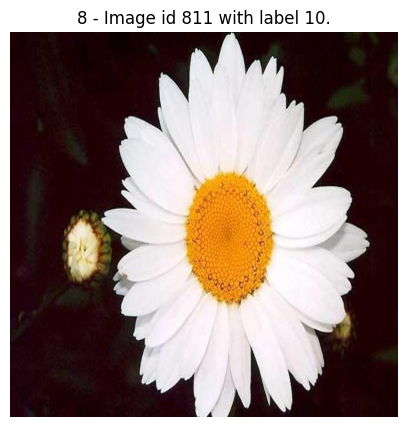

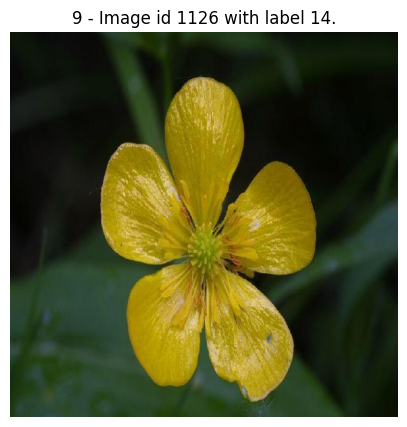

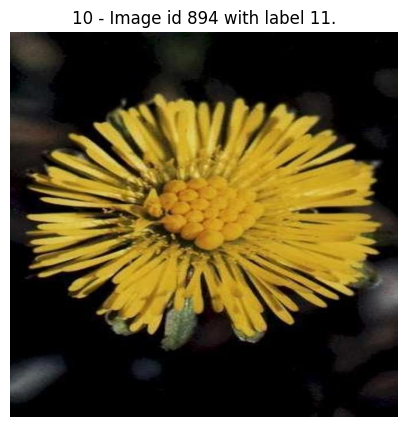

Accuracy for image id 1011: 10.00%
.//jpg/12/image_1011.jpg
Image: 1011 with label 12
Closest image: 1011 with distance 0.0 and label 12
Distances:  [[0.         0.04560623 0.04704062 0.04842293 0.0567597  0.06133224
  0.07022383 0.07140937 0.07860249 0.08206012 0.0885307 ]]
Indices:  [252 201 184 207 294 107 258 298 202 284 223]
Labels:  [12, 10, 9, 10, 14, 5, 12, 14, 10, 14, 11]


In [56]:
# For a random image of the testing split of the dataset, use the image as the query
# for the image retrieval problem, i.e., describe the image using the BoVW, and search
# for the k closest descriptors of the images in the testing split dataset. After that,
# measure the accuracy of the image retrieval by counting how many of the k retrieved 
# images has the same label of the query image, and divide it by k. This result will 
# the accuracy of the image retrieval result for that specific image.
# Also display the query image, and all k images returned by the image retrieval problem.
# For each returned image, also display its class, and the Euclidean distance between its
# descriptor and the descriptor of the query image.
# Since the query image also is in the testing split of the dataset, it is expected that the
# first returned image is the query image itself, and the distance between the descriptor to 
# be zero.

retrieve_single_image( space, labels, dictionary, dataset_path , algorithm=algorithm)

2. Execute o código e calcule a acurácia média para os três casos.

In [61]:
results = {}
for alg in ['random', 'grid', 'lbp']:
    print(f"\n--- Testing algorithm: {alg} ---")
    space, labels, dictionary = execution_algoithm(dataset_path,alg,num_cluster )
    acc = run_test(space, labels, dictionary, dataset_path, algorithm=alg)
    results[alg] = acc
    


--- Testing algorithm: random ---


Processing train set: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [00:03<00:00, 191.25it/s]


 -> [I] Image Loader Info:
 
Train len:  160876 
Number of images:  680 
Descriptor size:  32
 -> [I] Dictionary Info:
 
Train len:  160876 
Dimension:  32 
Clusters:  100
Learning dictionary by Kmeans...
Done.


Processing test set: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:01<00:00, 326.78it/s]


 -> [I] Space Describing Info:
 
Number of images:  340 
Number of labels:  340 
Dimension:  100


running the test phase: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:01<00:00, 304.91it/s]


Average accuracy in the test set:  3.12%

--- Testing algorithm: grid ---


Processing train set: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 680/680 [00:26<00:00, 26.12it/s]


 -> [I] Image Loader Info:
 
Train len:  1361994 
Number of images:  680 
Descriptor size:  32
 -> [I] Dictionary Info:
 
Train len:  1361994 
Dimension:  32 
Clusters:  100
Learning dictionary by Kmeans...
Done.


Processing test set: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:03<00:00, 105.97it/s]


 -> [I] Space Describing Info:
 
Number of images:  340 
Number of labels:  340 
Dimension:  100


running the test phase: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [-1:59:59<00:00, -182.60it/s]


Average accuracy in the test set: 13.35%

--- Testing algorithm: lbp ---


Processing test set: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:20<00:00, 16.44it/s]


 -> [I] Space Describing Info:
 
Number of images:  340 
Number of labels:  340 
Dimension:  10


running the test phase: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 340/340 [00:12<00:00, 26.90it/s]

Average accuracy in the test set:  9.29%


3. Compare a acurácia média com a acurácia média entre todas as representações.

Com base nos resultados obtidos:

Random: 3.12%
Grid: 13.35%
LBP: 9.29%
Média geral: ≈ 8.59%
  